In [0]:
!pip install pydrive
from google.colab import drive
drive.mount('/content/gdrive')


     |████████████████████████████████| 993kB 6.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import pickle
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [0]:
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    strain.append(np.abs(X.max()-X.min()))
    strain.append(X.median())
    return strain

In [0]:
root_path = 'gdrive/My Drive/your_project_folder/'  #change dir to your project folder
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

{}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [0]:
!kaggle competitions download -c LANL-Earthquake-Prediction -p /content/gdrive/My\ Drive/kaggle/lanl

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 6, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [0]:
import os
os.chdir('/content/gdrive/My Drive/kaggle/lanl')
!mkdir train  #create a directory named train/
!mkdir test  #create a directory named test/
!unzip -q train.csv.zip -d train/  #unzip data in train/

In [0]:
os.chdir('/content/gdrive/My Drive/kaggle/lanl/train') 
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64},engine='python')
X_train =[]
y_train = []
for df in tqdm(train):
    ch = gen_features(df['acoustic_data'])
    X_train.append(ch)
    y_train.append((np.mean(df['time_to_failure'])))
X_train=np.array(X_train)
y_train=np.array(y_train)
np.save("X_train",X_train)
np.save("y_train",y_train)

4195it [31:54,  2.81it/s]


In [0]:
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
os.chdir('/content/gdrive/My Drive/kaggle/lanl/train') 

X_train=np.load('X_train.npy')
y_train=np.load('y_train.npy')
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.2,0.3], #so called `eta` value
              'max_depth': [5,6,7,8],
              'silent': [1],
              'subsample': [0.5,0.6,0.7],
              'colsample_bytree': [0.5,0.6,0.7],
             'rate_drop':[0.1,0.2,0.3,0.4,0.5,0.6]}

xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=3,verbose=2)
xtrain, xvalid, ytrain, yvalid = train_test_split(X_train,y_train)
xgb_model = clf.fit(X_train,y_train)


Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 5828 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done 5832 out of 5832 | elapsed: 34.6min finished


In [0]:
clf.best_params_
parms_optimal={'colsample_bytree': 0.5,'learning_rate': 0.04,'max_depth': 5,'nthread': 4,
 'objective': 'reg:squarederror',
 'rate_drop': 0.1,
 'silent': 1,
 'subsample': 0.5}

In [0]:
X_train.shape,y_train.shape

((4195, 15), (4195,))

In [0]:
!pip install xgboost
import xgboost as xgb

xgb_model = xgb.XGBRegressor(max_depth=5,learning_rate=0.04,objective='reg:squarederror',n_jobs=-1,colsample_bytree=0.5,rate_drop=0.1,
                            verbosity=2,subsample=0.5)
xgb_model.fit(X_train,y_train)
xgb_model.save_model('mainxgboost.model')

[22:31:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:31:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[22:31:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[22:31:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:31:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:31:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:31:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:31:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nod

In [0]:
!pip install catboost
from catboost import CatBoostRegressor, Pool
import catboost
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train,verbose=True)

0:	learn: 5.6641122	total: 22.4ms	remaining: 3m 43s
1:	learn: 5.6492594	total: 43.2ms	remaining: 3m 35s
2:	learn: 5.6344263	total: 60.3ms	remaining: 3m 20s
3:	learn: 5.6196742	total: 79ms	remaining: 3m 17s
4:	learn: 5.6050798	total: 97.6ms	remaining: 3m 15s
5:	learn: 5.5905680	total: 117ms	remaining: 3m 15s
6:	learn: 5.5760810	total: 136ms	remaining: 3m 14s
7:	learn: 5.5616729	total: 155ms	remaining: 3m 13s
8:	learn: 5.5473761	total: 173ms	remaining: 3m 12s
9:	learn: 5.5331546	total: 192ms	remaining: 3m 11s
10:	learn: 5.5189845	total: 209ms	remaining: 3m 10s
11:	learn: 5.5048114	total: 214ms	remaining: 2m 58s
12:	learn: 5.4909175	total: 240ms	remaining: 3m 4s
13:	learn: 5.4769956	total: 260ms	remaining: 3m 5s
14:	learn: 5.4631462	total: 285ms	remaining: 3m 9s
15:	learn: 5.4493831	total: 303ms	remaining: 3m 8s
16:	learn: 5.4357053	total: 320ms	remaining: 3m 8s
17:	learn: 5.4221513	total: 339ms	remaining: 3m 7s
18:	learn: 5.4087059	total: 356ms	remaining: 3m 6s
19:	learn: 5.3952926	total

In [0]:
m.save_model("catboost.model")
m.best_score_

{'learn': {'MAE': 1.793845582395613}}

Using TensorFlow backend.
W0727 23:03:25.260754 140663963035520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 23:03:25.329705 140663963035520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 23:03:25.342324 140663963035520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 23:03:25.471168 140663963035520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instea

Train on 4195 samples, validate on 1049 samples
Epoch 1/250
4195/4195 [==============================] - 5s 1ms/step - loss: 34.4931 - mean_squared_error: 34.4931 - val_loss: 24.9285 - val_mean_squared_error: 24.9285
Epoch 2/250
4195/4195 [==============================] - 1s 197us/step - loss: 14.2773 - mean_squared_error: 14.2773 - val_loss: 11.0039 - val_mean_squared_error: 11.0039
Epoch 3/250
4195/4195 [==============================] - 1s 188us/step - loss: 9.0733 - mean_squared_error: 9.0733 - val_loss: 10.0639 - val_mean_squared_error: 10.0639
Epoch 4/250
4195/4195 [==============================] - 1s 180us/step - loss: 8.8827 - mean_squared_error: 8.8827 - val_loss: 9.5205 - val_mean_squared_error: 9.5205
Epoch 5/250
4195/4195 [==============================] - 1s 179us/step - loss: 8.8733 - mean_squared_error: 8.8733 - val_loss: 9.0542 - val_mean_squared_error: 9.0542
Epoch 6/250
4195/4195 [==============================] - 1s 179us/step - loss: 8.8365 - mean_squared_error: 8

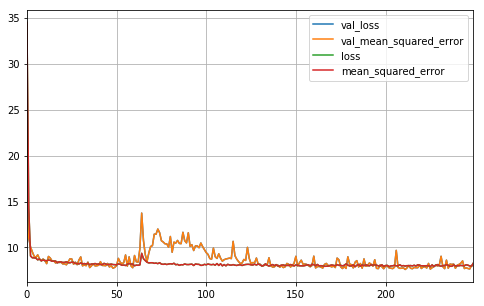

In [0]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from tensorflow import keras
from keras import optimizers
from sklearn.model_selection import train_test_split
from tqdm import tqdm
xtrain, xvalid, ytrain, yvalid = train_test_split(X_train,y_train)
model = Sequential()
model.add(Dense(64, input_dim=15, activation= "relu"))
model.add(BatchNormalization())
# model.add(Dense(256,activation= "relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(64,activation= "relu"))
# model.add(BatchNormalization())
model.add(Dense(1,activation='linear'))


model.compile(loss= "mean_squared_error" , optimizer='adam', metrics=["mean_squared_error"])

history=model.fit(X_train,y_train,epochs=250,validation_data=(xvalid, yvalid))
model.save("kerasmodel.h5")
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()



In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')